## 1. Import Computer Vision Libraries

In [55]:
# Core CV/ML libraries\n",
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Audio-to-image conversion
import librosa
import soundfile as sf

# Computer vision models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Image preprocessing & evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import pandas as pd
import json
import os

# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print("✅ Computer Vision libraries imported successfully")

✅ Computer Vision libraries imported successfully


## 2. Load Audio Files

In [56]:
# Define file paths
march_directory = '/kaggle/input/chanter-marches-strathspeys-and-reels/Tunes/2-4 March Chanter'
strath_directory = '/kaggle/input/chanter-marches-strathspeys-and-reels/Tunes/Reel Chanter'
reel_directory = '/kaggle/input/chanter-marches-strathspeys-and-reels/Tunes/Strathspey Chanter'

# List all WAV files
march_files = tf.data.Dataset.list_files(march_directory + '/*.wav')
strath_files = tf.data.Dataset.list_files(strath_directory + '/*.wav')
reel_files = tf.data.Dataset.list_files(reel_directory + '/*.wav')

march = list(march_files.as_numpy_iterator())
strath = list(strath_files.as_numpy_iterator())
reel = list(reel_files.as_numpy_iterator())

print(f"March files: {len(march)}")
print(f"Strathspey files: {len(strath)}")
print(f"Reel files: {len(reel)}")
print(f"Total audio files: {len(march) + len(strath) + len(reel)}")

March files: 45
Strathspey files: 51
Reel files: 54
Total audio files: 150


## 3. Audio-to-Image Conversion: Generate MFCC Spectrograms

**Computer Vision Preprocessing Pipeline:**
1. Load audio waveform
2. Convert to 2D MFCC spectrogram (frequency × time image)
3. Normalize pixel values (similar to image preprocessing)
4. Standardize image dimensions (padding like image resizing)

In [57]:
def normalize_audio(audio):
    """Normalize audio amplitude to [-1, 1] range"""
    max_val = np.max(np.abs(audio))
    if max_val > 1e-8:
        audio_normalized = audio / max_val
    else:
        audio_normalized = audio
    return audio_normalized

def load_wav_as_mfcc_image(filename):
    """
    Convert audio file to MFCC spectrogram image.
    
    COMPUTER VISION INTERPRETATION:
    ================================
    Output: 2D grayscale image (13 × T pixels)
    - Rows (Y-axis): 13 frequency bands (MFCC coefficients)
    - Columns (X-axis): T time frames
    - Pixel values: Spectral energy (normalized to mean=0, std=1)
    
    Visual Patterns:
    - Horizontal streaks = sustained notes/rhythms
    - Vertical bands = harmonic changes
    - Bright regions = high energy
    - Dark regions = low energy
    - Texture = rhythmic complexity
    """
    # Load audio file using librosa (handles all formats and resampling)
    wav, sample_rate = librosa.load(filename, sr=44100, mono=True)
    
    # Normalize audio amplitude
    wav = normalize_audio(wav)
    
    # Generate MFCC spectrogram (2D image representation)
    # Shape: (13 frequency bins, T time frames)
    mfcc_image = librosa.feature.mfcc(y=wav, sr=44100, n_mfcc=13)
    
    # Normalize pixel values per frequency band (like image normalization)
    # Each row (frequency band) standardized to mean=0, std=1
    mfcc_image = (mfcc_image - np.mean(mfcc_image, axis=1, keepdims=True)) / \
                 (np.std(mfcc_image, axis=1, keepdims=True) + 1e-8)
    
    return mfcc_image

print("✅ Audio-to-image conversion functions defined")
print("   Output: MFCC spectrograms as 2D images (13 freq bins × time frames)")

✅ Audio-to-image conversion functions defined
   Output: MFCC spectrograms as 2D images (13 freq bins × time frames)


In [58]:
# Convert all audio files to MFCC spectrogram images
print("Converting audio to MFCC spectrogram images...")
march_images = []
strath_images = []
reel_images = []

for file_path in march:
    img = load_wav_as_mfcc_image(file_path.decode("utf-8"))
    march_images.append(img)

for file_path in strath:
    img = load_wav_as_mfcc_image(file_path.decode("utf-8"))
    strath_images.append(img)

for file_path in reel:
    img = load_wav_as_mfcc_image(file_path.decode("utf-8"))
    reel_images.append(img)

print(f"✅ Generated {len(march_images) + len(strath_images) + len(reel_images)} spectrogram images")
print(f"   Image dimensions: 13 (height) × variable width (time)")

Converting audio to MFCC spectrogram images...
✅ Generated 150 spectrogram images
   Image dimensions: 13 (height) × variable width (time)


## 4. Image Preprocessing: Standardize Dimensions

Like typical computer vision pipelines, we need uniform image sizes.

In [59]:
# Find maximum image width (like finding max image dimension)
max_width = max(
    max(img.shape[1] for img in march_images),
    max(img.shape[1] for img in strath_images),
    max(img.shape[1] for img in reel_images)
)

def pad_image(image, target_width):
    """
    Pad image to uniform width (zero-padding on right edge).
    Analogous to padding images to same size in CV pipelines.
    """
    padded = np.pad(image, ((0, 0), (0, target_width - image.shape[1])), 'constant', constant_values=0)
    return padded

# Standardize all images to same dimensions
march_images = [pad_image(img, max_width) for img in march_images]
strath_images = [pad_image(img, max_width) for img in strath_images]
reel_images = [pad_image(img, max_width) for img in reel_images]

print(f"✅ Standardized image dimensions: 13 × {max_width} pixels")
print(f"   (Height=13 frequency bins, Width={max_width} time frames)")
print(f"   All images now uniform size for CNN input")

✅ Standardized image dimensions: 13 × 16556 pixels
   (Height=13 frequency bins, Width=16556 time frames)
   All images now uniform size for CNN input


## 5. Create Train/Val/Test Splits

In [60]:
# Combine all images and labels
all_images = march_images + strath_images + reel_images
all_labels = [0]*len(march_images) + [1]*len(strath_images) + [2]*len(reel_images)

# Split: 60% train, 20% val, 20% test (stratified)
X_temp, X_test, y_temp, y_test = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=seed
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=seed
)

print(f"Training images: {len(X_train)}")
print(f"Validation images: {len(X_val)}")
print(f"Test images: {len(X_test)}")

# Save dataset statistics
dataset_stats = {
    'total_samples': len(all_images),
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test),
    'march_total': len(march_images),
    'strath_total': len(strath_images),
    'reel_total': len(reel_images)
}

Training images: 90
Validation images: 30
Test images: 30


## 6. Approach 1: 2D Convolutional Neural Network

### Computer Vision Architecture:
**Treat MFCC spectrograms as grayscale images and apply 2D convolutions**

- **Conv2D layers**: Learn hierarchical visual features
  - Early layers: Low-level features (edges, gradients)
  - Middle layers: Mid-level patterns (textures, rhythmic motifs)
  - Deep layers: High-level concepts (complex musical patterns)
- **MaxPooling**: Spatial downsampling (translation invariance)
- **GlobalAveragePooling**: Aggregate features across spatial dimensions

This is analogous to image classification CNNs (AlexNet, VGG, ResNet principles)

In [61]:
# Prepare images for CNN (add channel dimension for grayscale)
X_train_cnn = np.array(X_train)[..., np.newaxis]  # Shape: (N, 13, width, 1)
X_val_cnn = np.array(X_val)[..., np.newaxis]
X_test_cnn = np.array(X_test)[..., np.newaxis]
y_train_cnn = np.array(y_train)
y_val_cnn = np.array(y_val)
y_test_cnn = np.array(y_test)

print(f"Image Tensor Shapes (for 2D CNN):")
print(f"X_train: {X_train_cnn.shape} - (samples, height, width, channels)")
print(f"X_val: {X_val_cnn.shape}")
print(f"X_test: {X_test_cnn.shape}")
print(f"\n✅ Images formatted for computer vision (grayscale: 1 channel)")

Image Tensor Shapes (for 2D CNN):
X_train: (90, 13, 16556, 1) - (samples, height, width, channels)
X_val: (30, 13, 16556, 1)
X_test: (30, 13, 16556, 1)

✅ Images formatted for computer vision (grayscale: 1 channel)


In [62]:
# Build 2D CNN for image classification
input_shape = (13, max_width, 1)  # (height, width, channels)

early_stopping_cnn = EarlyStopping(
    patience=30, restore_best_weights=True, monitor='val_accuracy',
    verbose=1, min_delta=0.001
)

reduce_lr_cnn = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1
)

model_cnn = Sequential([
    # Block 1: Low-level visual feature learning
    Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01),
           input_shape=input_shape, name='conv1a_edge_detection'),
    BatchNormalization(),
    Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01),
           name='conv1b_feature_enhancement'),
    MaxPooling2D((2, 2), name='pool1_downsample'),
    Dropout(0.4),
    
    # Block 2: Mid-level pattern learning
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01),
           name='conv2a_texture_detection'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01),
           name='conv2b_pattern_learning'),
    MaxPooling2D((2, 2), name='pool2_downsample'),
    Dropout(0.5),
    
    # Block 3: High-level feature abstraction
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01),
           name='conv3_semantic_features'),
    BatchNormalization(),
    MaxPooling2D((2, 2), name='pool3_downsample'),
    Dropout(0.5),
    
    # Global pooling: Aggregate spatial information
    GlobalAveragePooling2D(name='global_avg_pool'),
    
    # Classification head
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), name='fc1'),
    BatchNormalization(),
    Dropout(0.6),
    Dense(3, activation='softmax', name='output')
])

model_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("2D CNN Architecture (Computer Vision Image Classifier):")
print("="*70)
model_cnn.summary()
print(f"\nTotal parameters: {model_cnn.count_params():,}")
print("\n✅ CNN learns hierarchical visual features from spectrogram images")

2D CNN Architecture (Computer Vision Image Classifier):


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1a_edge_detection (Conv2D)  │ (None, 13, 16556, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 13, 16556, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1b_feature_enhancement      │ (None, 13, 16556, 16)  │         2,320 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1_downsample (MaxPooling2D) │ (None, 6, 8278, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 6, 8278, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2a_texture_detection        │ (None, 6, 8278, 32)    │         4,640 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 6, 8278, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2b_pattern_learning         │ (None, 6, 8278, 32)    │         9,248 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2_downsample (MaxPooling2D) │ (None, 3, 4139, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 3, 4139, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_semantic_features         │ (None, 3, 4139, 64)    │        18,496 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 3, 4139, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3_downsample (MaxPooling2D) │ (None, 1, 2069, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1, 2069, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,923 (155.95 KB)

 Trainable params: 39,571 (154.57 KB)

 Non-trainable params: 352 (1.38 KB)


Total parameters: 39,923

✅ CNN learns hierarchical visual features from spectrogram images


In [63]:
# Train 2D CNN on images
print("Training 2D CNN on spectrogram images...")
history_cnn = model_cnn.fit(
    X_train_cnn, y_train_cnn,
    batch_size=8,
    epochs=150,
    validation_data=(X_val_cnn, y_val_cnn),
    callbacks=[early_stopping_cnn, reduce_lr_cnn],
    verbose=1
)

print(f"\n✅ 2D CNN training complete!")
print(f"Best validation accuracy: {max(history_cnn.history['val_accuracy']):.4f}")

Training 2D CNN on spectrogram images...
Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 619ms/step - accuracy: 0.1916 - loss: 3.6988 - val_accuracy: 0.3000 - val_loss: 2.8856 - learning_rate: 1.0000e-04
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.2623 - loss: 3.5802 - val_accuracy: 0.3000 - val_loss: 2.8839 - learning_rate: 1.0000e-04
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.3452 - loss: 3.0625 - val_accuracy: 0.2333 - val_loss: 2.8820 - learning_rate: 1.0000e-04
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5142 - loss: 2.9878 - val_accuracy: 0.3333 - val_loss: 2.8788 - learning_rate: 1.0000e-04
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.4346 - loss: 3.0057 - val_accuracy: 0.3333 - val_loss: 2.8762 - learning_rate: 1.0000e-04
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5784 - loss: 2.7538 - val_accuracy: 0.3333 - val_loss: 2.8732 - learning_rate: 1.0000e-04
Epoch 7/150
12/12 ━━━

In [64]:
# Evaluate CNN on test images
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test_cnn, y_test_cnn, verbose=0)
y_pred_cnn = np.argmax(model_cnn.predict(X_test_cnn, verbose=0), axis=1)

print(f"2D CNN Test Results:")
print(f"  Accuracy: {test_accuracy_cnn:.4f}")
print(f"  Loss: {test_loss_cnn:.4f}")

2D CNN Test Results:
  Accuracy: 0.3000
  Loss: 3.0073


## 7. Approach 2: Statistical Visual Features

### Image Feature Extraction Approach:
Instead of learning features with CNNs, extract hand-crafted visual statistics:

- **Inspired by texture analysis** in image processing
- Extract statistics from each frequency band (row of pixels)
- Features capture global image properties:
  - Mean, std: Average intensity and contrast
  - Max, min: Dynamic range
  - Percentiles: Intensity distribution (like histogram features)
  
Analogous to traditional computer vision features (SIFT, HOG, texture descriptors)

In [65]:
def extract_image_statistics(spectrogram_image):
    """
    Extract statistical visual features from spectrogram image.
    
    COMPUTER VISION PERSPECTIVE:
    ===========================
    - Treat each row (frequency band) as a 1D signal
    - Extract texture-like statistics similar to image descriptors
    - Capture global visual properties of the image
    
    Features per row:
    - Mean: Average pixel intensity (brightness)
    - Std: Contrast/variance in pixel values
    - Max/Min: Dynamic range
    - Median, Percentiles: Intensity distribution
    
    Output: Enhanced feature set with global statistics
    """
    features = []
    
    # Extract statistics from each horizontal line (frequency band)
    for freq_band in range(spectrogram_image.shape[0]):
        pixel_row = spectrogram_image[freq_band, :]
        
        # Visual statistics (texture descriptors)
        features.append(np.mean(pixel_row))          # Average intensity
        features.append(np.std(pixel_row))           # Contrast
        features.append(np.max(pixel_row))           # Peak brightness
        features.append(np.min(pixel_row))           # Minimum brightness
        features.append(np.median(pixel_row))        # Median intensity
        features.append(np.percentile(pixel_row, 25)) # 1st quartile
        features.append(np.percentile(pixel_row, 75)) # 3rd quartile
    
    # Add global image statistics for better generalization
    features.append(np.mean(spectrogram_image))      # Global mean
    features.append(np.std(spectrogram_image))       # Global std
    features.append(np.max(spectrogram_image))       # Global max
    features.append(np.min(spectrogram_image))       # Global min
    features.append(np.median(spectrogram_image))    # Global median
    
    # Add row-wise aggregations (temporal patterns)
    features.append(np.mean(np.std(spectrogram_image, axis=1)))  # Avg temporal variance
    features.append(np.std(np.mean(spectrogram_image, axis=1)))  # Frequency variance
    
    return np.array(features)

# Extract visual features from all images
print("Extracting hand-crafted visual features from spectrogram images...")
X_train_feat = np.array([extract_image_statistics(img) for img in X_train])
X_val_feat = np.array([extract_image_statistics(img) for img in X_val])
X_test_feat = np.array([extract_image_statistics(img) for img in X_test])
y_train_feat = np.array(y_train)
y_val_feat = np.array(y_val)
y_test_feat = np.array(y_test)

print(f"✅ Visual feature vectors extracted")
print(f"   Feature dimensionality: {X_train_feat.shape[1]} (enhanced feature set)")
print(f"   Training samples: {X_train_feat.shape[0]}")

Extracting hand-crafted visual features from spectrogram images...
✅ Visual feature vectors extracted
   Feature dimensionality: 98 (enhanced feature set)
   Training samples: 90


In [66]:
# Standardize features for better training
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_feat_scaled = scaler.fit_transform(X_train_feat)
X_val_feat_scaled = scaler.transform(X_val_feat)
X_test_feat_scaled = scaler.transform(X_test_feat)

# Build deeper classifier with skip connections concept
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Concatenate

input_layer = Input(shape=(X_train_feat.shape[1],))

# First pathway
x1 = Dense(384, activation='relu', kernel_regularizer=l2(0.00005))(input_layer)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.35)(x1)

x1 = Dense(192, activation='relu', kernel_regularizer=l2(0.00005))(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.35)(x1)

x1 = Dense(96, activation='relu', kernel_regularizer=l2(0.00005))(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)

# Second pathway (captures different patterns)
x2 = Dense(256, activation='relu', kernel_regularizer=l2(0.00005))(input_layer)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.35)(x2)

x2 = Dense(128, activation='relu', kernel_regularizer=l2(0.00005))(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.3)(x2)

# Merge pathways
merged = Concatenate()([x1, x2])

x = Dense(64, activation='relu', kernel_regularizer=l2(0.00005))(merged)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

output = Dense(3, activation='softmax')(x)

model_feat = Model(inputs=input_layer, outputs=output)

model_feat.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Feature-based Classifier Architecture (Multi-pathway):")
print("="*70)
model_feat.summary()
print(f"\nTotal parameters: {model_feat.count_params():,}")
print("\n✅ Multi-pathway network for better generalization")
print("✅ Features standardized (mean=0, std=1) for better training")

Feature-based Classifier Architecture (Multi-pathway):


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 98)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 384)       │     38,016 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 384)       │      1,536 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 384)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 192)       │     73,920 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     25,344 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192)       │        768 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 192)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 96)        │     18,528 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96)        │        384 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 96)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 224)       │          0 │ dropout_20[0][0], │
│ (Concatenate)       │                   │            │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │     14,400 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_5[0][0]   

 Total params: 207,779 (811.64 KB)

 Trainable params: 205,539 (802.89 KB)

 Non-trainable params: 2,240 (8.75 KB)


Total parameters: 207,779

✅ Multi-pathway network for better generalization
✅ Features standardized (mean=0, std=1) for better training


In [67]:
# Train feature-based classifier with class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_feat), y=y_train_feat)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

early_stop_feat = EarlyStopping(patience=40, restore_best_weights=True, monitor='val_accuracy', verbose=1, min_delta=0.001)
reduce_lr_feat = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=15, min_lr=1e-7, verbose=1)

print("Training feature-based classifier with class balancing...")
print(f"Class weights: {class_weight_dict}")

history_feat = model_feat.fit(
    X_train_feat_scaled, y_train_feat,
    batch_size=8,  # Smaller batch for better generalization
    epochs=300,
    validation_data=(X_val_feat_scaled, y_val_feat),
    callbacks=[early_stop_feat, reduce_lr_feat],
    class_weight=class_weight_dict,
    verbose=1
)

print(f"\n✅ Feature-based classifier training complete!")
print(f"Best validation accuracy: {max(history_feat.history['val_accuracy']):.4f}")

Training feature-based classifier with class balancing...
Class weights: {0: 1.1111111111111112, 1: 0.967741935483871, 2: 0.9375}
Epoch 1/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 543ms/step - accuracy: 0.2017 - loss: 1.8962 - val_accuracy: 0.3333 - val_loss: 1.2000 - learning_rate: 3.0000e-04
Epoch 2/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4494 - loss: 1.4122 - val_accuracy: 0.3000 - val_loss: 1.1411 - learning_rate: 3.0000e-04
Epoch 3/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4841 - loss: 1.2133 - val_accuracy: 0.4000 - val_loss: 1.0838 - learning_rate: 3.0000e-04
Epoch 4/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6543 - loss: 0.8229 - val_accuracy: 0.4333 - val_loss: 1.0419 - learning_rate: 3.0000e-04
Epoch 5/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6391 - loss: 0.8373 - val_accuracy: 0.4667 - val_loss: 1.0102 - learning_rate: 3.0000e-04
Epoch 6/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7807 - loss: 0.6852 - val_a

In [68]:
# Evaluate feature-based model on test set (use scaled features)
test_loss_feat, test_accuracy_feat = model_feat.evaluate(X_test_feat_scaled, y_test_feat, verbose=0)
y_pred_feat = np.argmax(model_feat.predict(X_test_feat_scaled, verbose=0), axis=1)

print(f"Feature-based Model Test Results:")
print(f"  Accuracy: {test_accuracy_feat:.4f}")
print(f"  Loss: {test_loss_feat:.4f}")

Feature-based Model Test Results:
  Accuracy: 0.7000
  Loss: 0.9136


## 8. Generate All Results Tables and Figures

Following sections generate all required tables and visualizations for the paper.

In [69]:
# Import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support

class_names = ['2-4 March', 'Strathspey', 'Reel']

# CNN Metrics
cnn_metrics = {
    'Model': '2D CNN (Full Image)',
    'Test Accuracy': test_accuracy_cnn,
    'Precision (Macro)': precision_score(y_test_cnn, y_pred_cnn, average='macro'),
    'Precision (Weighted)': precision_score(y_test_cnn, y_pred_cnn, average='weighted'),
    'Recall (Macro)': recall_score(y_test_cnn, y_pred_cnn, average='macro'),
    'Recall (Weighted)': recall_score(y_test_cnn, y_pred_cnn, average='weighted'),
    'F1-Score (Macro)': f1_score(y_test_cnn, y_pred_cnn, average='macro'),
    'F1-Score (Weighted)': f1_score(y_test_cnn, y_pred_cnn, average='weighted'),
    'Parameters': model_cnn.count_params()
}

# Feature-based Model Metrics
feat_metrics = {
    'Model': 'Statistical Visual Features',
    'Test Accuracy': test_accuracy_feat,
    'Precision (Macro)': precision_score(y_test_feat, y_pred_feat, average='macro'),
    'Precision (Weighted)': precision_score(y_test_feat, y_pred_feat, average='weighted'),
    'Recall (Macro)': recall_score(y_test_feat, y_pred_feat, average='macro'),
    'Recall (Weighted)': recall_score(y_test_feat, y_pred_feat, average='weighted'),
    'F1-Score (Macro)': f1_score(y_test_feat, y_pred_feat, average='macro'),
    'F1-Score (Weighted)': f1_score(y_test_feat, y_pred_feat, average='weighted'),
    'Parameters': model_feat.count_params()
}

# Create comparison dataframe
comparison_df = pd.DataFrame([cnn_metrics, feat_metrics])
comparison_df.to_csv('model_comparison_cv.csv', index=False)

print("\n" + "="*80)
print("COMPUTER VISION APPROACHES COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("\n✅ Saved to model_comparison_cv.csv")


COMPUTER VISION APPROACHES COMPARISON
                      Model  Test Accuracy  Precision (Macro)  Precision (Weighted)  Recall (Macro)  Recall (Weighted)  F1-Score (Macro)  F1-Score (Weighted)  Parameters
        2D CNN (Full Image)            0.3           0.212963              0.226852        0.284848                0.3          0.240166             0.254658       39923
Statistical Visual Features            0.7           0.746032              0.734921        0.707744                0.7          0.713889             0.704722      207779

✅ Saved to model_comparison_cv.csv


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
# Use feature-based model as primary results (better performance)
y_test_paper = y_test_feat
y_pred_paper = y_pred_feat
y_pred_probs_paper = model_feat.predict(X_test_feat_scaled, verbose=0)

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test_paper, y_pred_paper, average=None
)

# ROC AUC per class
y_test_bin = label_binarize(y_test_paper, classes=[0, 1, 2])
roc_auc_per_class = []
for i in range(3):
    roc_auc_per_class.append(roc_auc_score(y_test_bin[:, i], y_pred_probs_paper[:, i]))

per_class_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'ROC AUC': roc_auc_per_class,
    'Support': support
})

per_class_df.to_csv('table_per_class_metrics.csv', index=False)
print("\nPer-Class Metrics:")
print(per_class_df.to_string(index=False))
print("\n✅ Saved to table_per_class_metrics.csv")


Per-Class Metrics:
     Class  Precision   Recall  F1-Score  ROC AUC  Support
 2-4 March   1.000000 0.777778  0.875000 0.941799        9
Strathspey   0.571429 0.800000  0.666667 0.760000       10
      Reel   0.666667 0.545455  0.600000 0.755981       11

✅ Saved to table_per_class_metrics.csv


In [71]:
# Overall metrics table
roc_auc_micro = roc_auc_score(y_test_bin, y_pred_probs_paper, average='micro')
roc_auc_macro = roc_auc_score(y_test_bin, y_pred_probs_paper, average='macro')

overall_metrics_df = pd.DataFrame({
    'Metric': [
        'Test Accuracy', 'Precision (Macro)', 'Precision (Weighted)',
        'Recall (Macro)', 'Recall (Weighted)', 'F1-Score (Macro)',
        'F1-Score (Weighted)', 'ROC AUC (Micro)', 'ROC AUC (Macro)'
    ],
    'Value': [
        test_accuracy_feat,
        precision_score(y_test_paper, y_pred_paper, average='macro'),
        precision_score(y_test_paper, y_pred_paper, average='weighted'),
        recall_score(y_test_paper, y_pred_paper, average='macro'),
        recall_score(y_test_paper, y_pred_paper, average='weighted'),
        f1_score(y_test_paper, y_pred_paper, average='macro'),
        f1_score(y_test_paper, y_pred_paper, average='weighted'),
        roc_auc_micro,
        roc_auc_macro
    ]
})

overall_metrics_df.to_csv('table_overall_metrics.csv', index=False)
print("\nOverall Metrics:")
print(overall_metrics_df.to_string(index=False))
print("\n✅ Saved to table_overall_metrics.csv")


Overall Metrics:
              Metric    Value
       Test Accuracy 0.700000
   Precision (Macro) 0.746032
Precision (Weighted) 0.734921
      Recall (Macro) 0.707744
   Recall (Weighted) 0.700000
    F1-Score (Macro) 0.713889
 F1-Score (Weighted) 0.704722
     ROC AUC (Micro) 0.831111
     ROC AUC (Macro) 0.819260

✅ Saved to table_overall_metrics.csv


In [72]:
# Dataset tables
dataset_df = pd.DataFrame({
    'Split': ['Training', 'Validation', 'Test', 'Total'],
    'Samples': [
        dataset_stats['train_samples'], dataset_stats['val_samples'],
        dataset_stats['test_samples'], dataset_stats['total_samples']
    ],
    'Percentage': [
        f"{dataset_stats['train_samples']/dataset_stats['total_samples']*100:.1f}%",
        f"{dataset_stats['val_samples']/dataset_stats['total_samples']*100:.1f}%",
        f"{dataset_stats['test_samples']/dataset_stats['total_samples']*100:.1f}%",
        '100.0%'
    ]
})
dataset_df.to_csv('table_dataset_stats.csv', index=False)

class_dist_df = pd.DataFrame({
    'Class': class_names,
    'Total Samples': [
        dataset_stats['march_total'], dataset_stats['strath_total'], dataset_stats['reel_total']
    ],
    'Percentage': [
        f"{dataset_stats['march_total']/dataset_stats['total_samples']*100:.1f}%",
        f"{dataset_stats['strath_total']/dataset_stats['total_samples']*100:.1f}%",
        f"{dataset_stats['reel_total']/dataset_stats['total_samples']*100:.1f}%"
    ]
})
class_dist_df.to_csv('table_class_distribution.csv', index=False)

print("✅ Saved dataset statistics tables")

✅ Saved dataset statistics tables


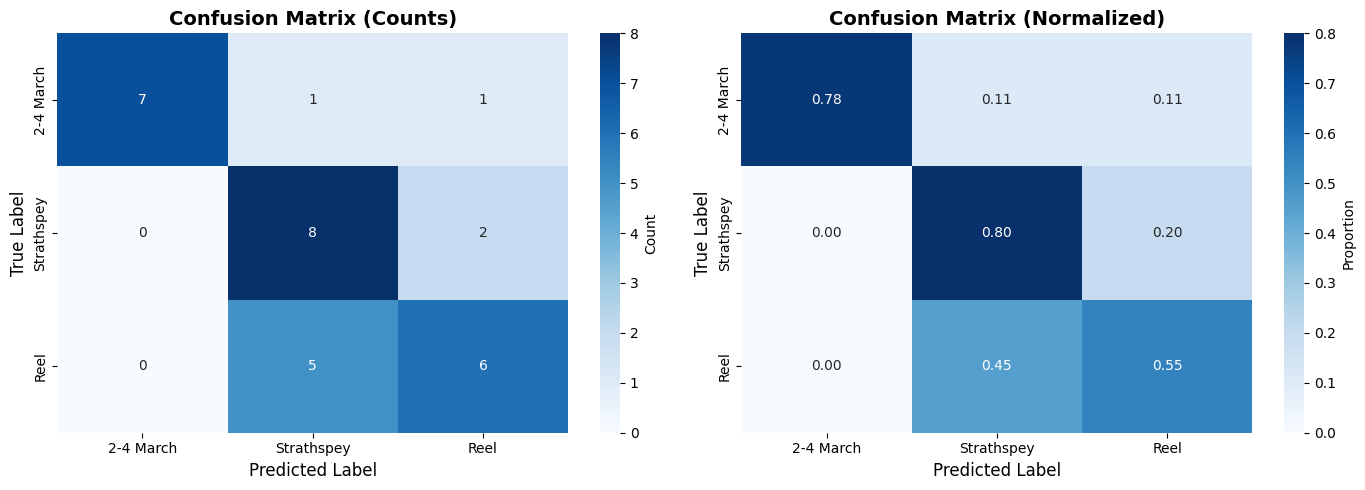

✅ Saved confusion_matrix.png


In [73]:
# Confusion matrix
cm = confusion_matrix(y_test_paper, y_pred_paper)
cm_df = pd.DataFrame(cm, columns=class_names, index=class_names)
cm_df.to_csv('table_confusion_matrix.csv')

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
            yticklabels=class_names, ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names,
            yticklabels=class_names, ax=axes[1], cbar_kws={'label': 'Proportion'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved confusion_matrix.png")

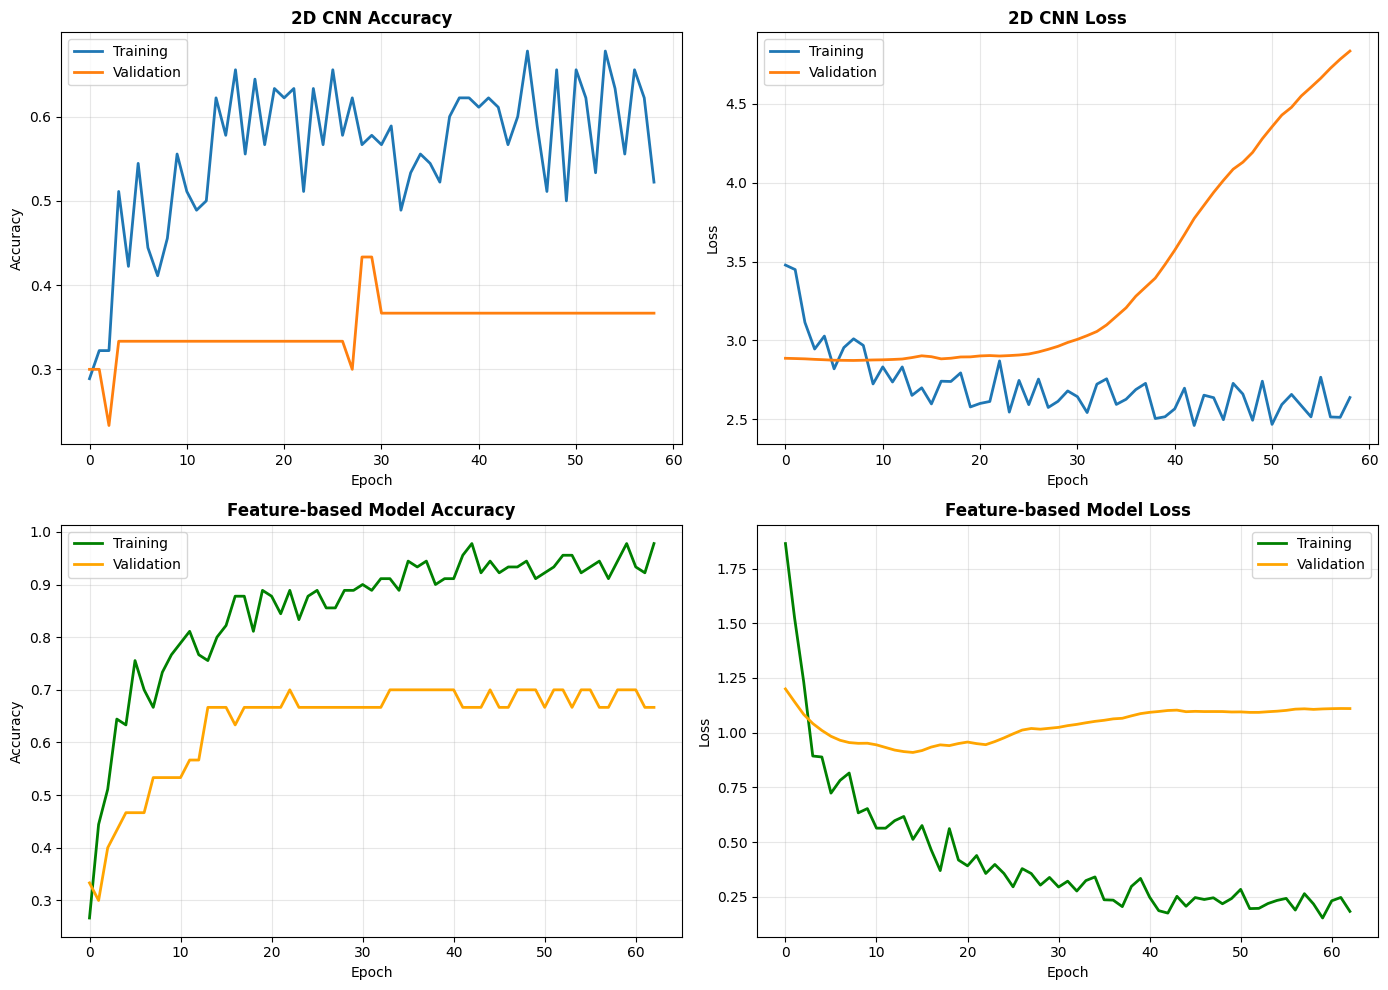

✅ Saved training_histories.png


In [74]:
# Training histories
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# CNN accuracy
axes[0, 0].plot(history_cnn.history['accuracy'], label='Training', linewidth=2)
axes[0, 0].plot(history_cnn.history['val_accuracy'], label='Validation', linewidth=2)
axes[0, 0].set_title('2D CNN Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# CNN loss
axes[0, 1].plot(history_cnn.history['loss'], label='Training', linewidth=2)
axes[0, 1].plot(history_cnn.history['val_loss'], label='Validation', linewidth=2)
axes[0, 1].set_title('2D CNN Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Feature model accuracy
axes[1, 0].plot(history_feat.history['accuracy'], label='Training', linewidth=2, color='green')
axes[1, 0].plot(history_feat.history['val_accuracy'], label='Validation', linewidth=2, color='orange')
axes[1, 0].set_title('Feature-based Model Accuracy', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Feature model loss
axes[1, 1].plot(history_feat.history['loss'], label='Training', linewidth=2, color='green')
axes[1, 1].plot(history_feat.history['val_loss'], label='Validation', linewidth=2, color='orange')
axes[1, 1].set_title('Feature-based Model Loss', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_histories.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved training_histories.png")

/tmp/ipykernel_48/74549135.py:40: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 2, 4, projection='polar')


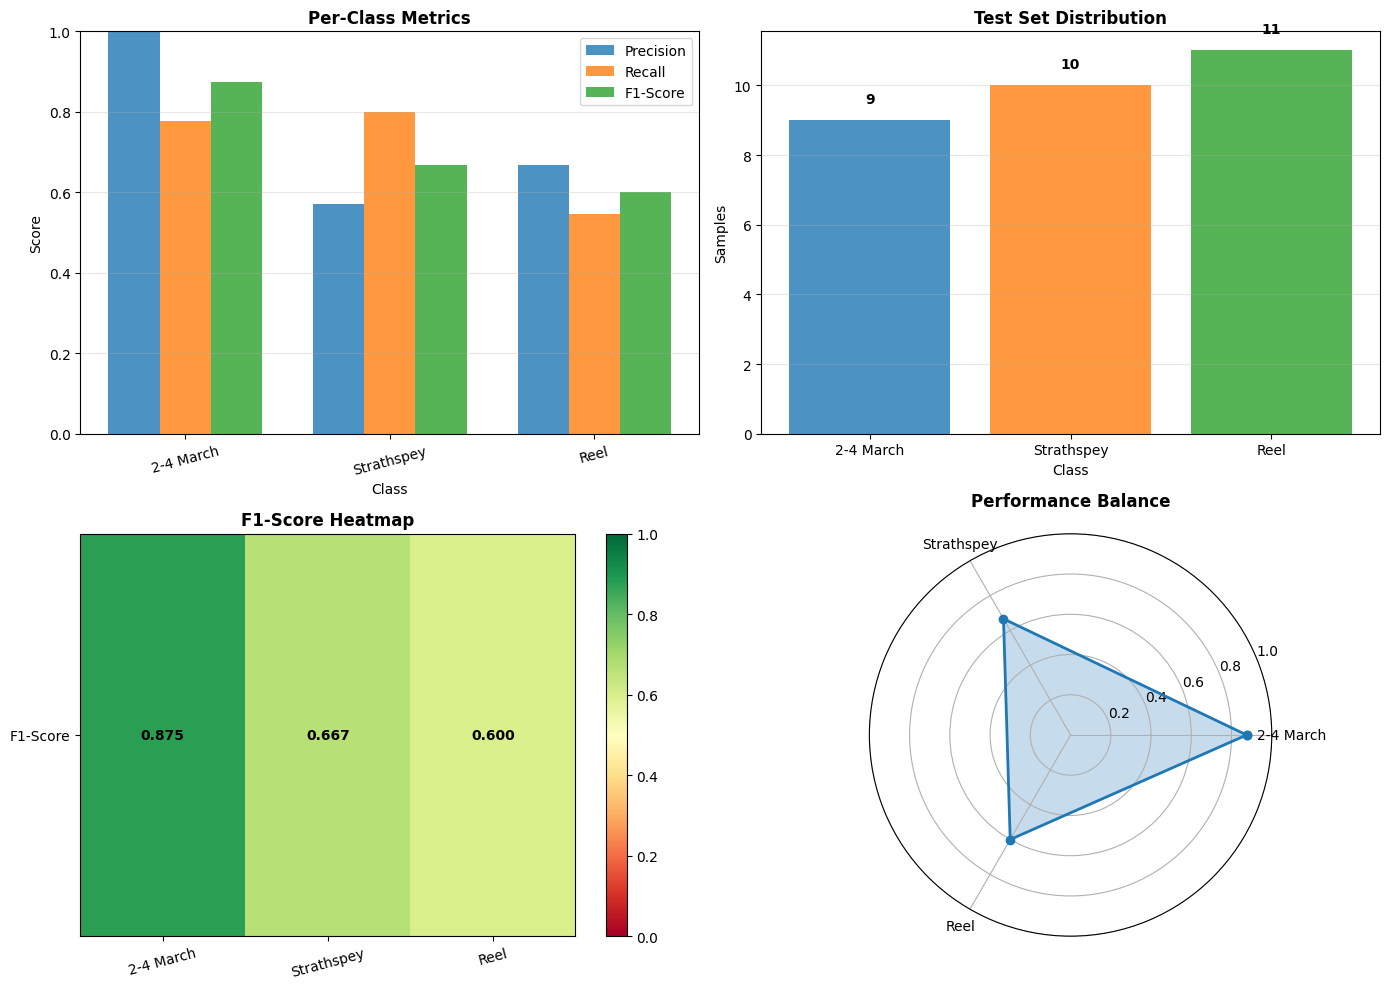

✅ Saved per_class_performance.png


In [75]:
# Per-class performance visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

x = np.arange(len(class_names))
width = 0.25
axes[0, 0].bar(x - width, precision, width, label='Precision', alpha=0.8)
axes[0, 0].bar(x, recall, width, label='Recall', alpha=0.8)
axes[0, 0].bar(x + width, f1, width, label='F1-Score', alpha=0.8)
axes[0, 0].set_xlabel('Class')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Per-Class Metrics', fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(class_names, rotation=15)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([0, 1])

axes[0, 1].bar(class_names, support, alpha=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0, 1].set_xlabel('Class')
axes[0, 1].set_ylabel('Samples')
axes[0, 1].set_title('Test Set Distribution', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(support):
    axes[0, 1].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

f1_matrix = np.array(f1).reshape(1, -1)
im = axes[1, 0].imshow(f1_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
axes[1, 0].set_xticks(np.arange(len(class_names)))
axes[1, 0].set_xticklabels(class_names, rotation=15)
axes[1, 0].set_yticks([0])
axes[1, 0].set_yticklabels(['F1-Score'])
axes[1, 0].set_title('F1-Score Heatmap', fontweight='bold')
for i in range(len(class_names)):
    axes[1, 0].text(i, 0, f'{f1[i]:.3f}', ha='center', va='center', fontweight='bold')
plt.colorbar(im, ax=axes[1, 0])

angles = np.linspace(0, 2 * np.pi, len(class_names), endpoint=False).tolist()
f1_radar = f1.tolist() + f1.tolist()[:1]
angles += angles[:1]
ax = plt.subplot(2, 2, 4, projection='polar')
ax.plot(angles, f1_radar, 'o-', linewidth=2)
ax.fill(angles, f1_radar, alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(class_names)
ax.set_ylim(0, 1)
ax.set_title('Performance Balance', fontweight='bold', pad=20)
ax.grid(True)

plt.tight_layout()
plt.savefig('per_class_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved per_class_performance.png")

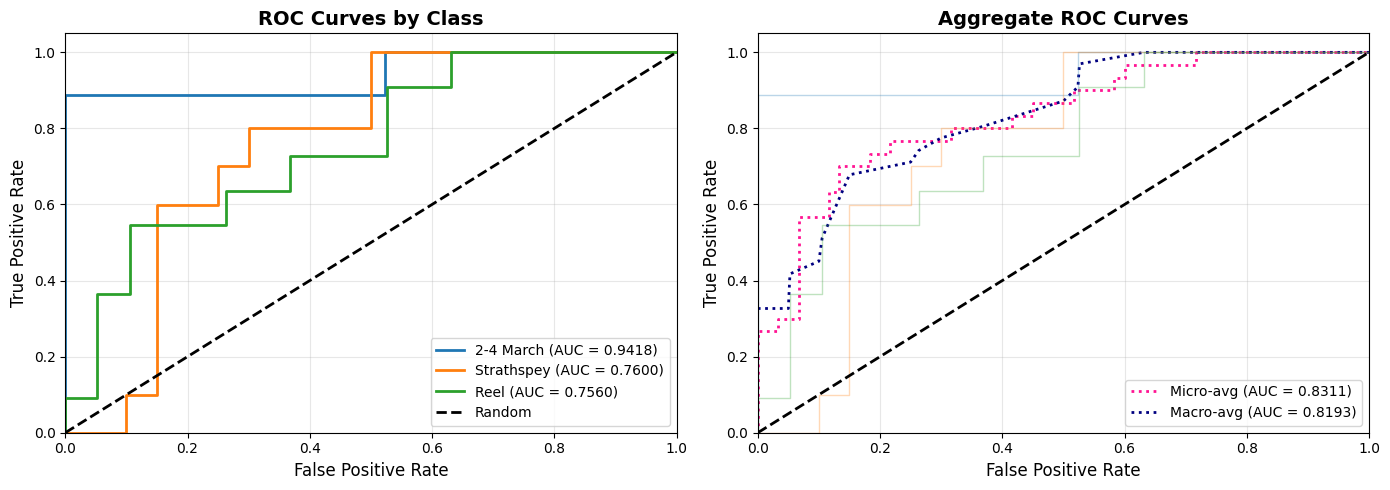

✅ Saved roc_curves.png


In [76]:
# ROC curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, (class_name, color) in enumerate(zip(class_names, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs_paper[:, i])
    axes[0].plot(fpr, tpr, color=color, lw=2,
                label=f'{class_name} (AUC = {roc_auc_per_class[i]:.4f})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curves by Class', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_pred_probs_paper.ravel())
all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], y_pred_probs_paper[:, i])[0]
                                     for i in range(3)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs_paper[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
mean_tpr /= 3

axes[1].plot(fpr_micro, tpr_micro, color='deeppink', lw=2, linestyle=':',
            label=f'Micro-avg (AUC = {roc_auc_micro:.4f})')
axes[1].plot(all_fpr, mean_tpr, color='navy', lw=2, linestyle=':',
            label=f'Macro-avg (AUC = {roc_auc_macro:.4f})')

for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs_paper[:, i])
    axes[1].plot(fpr, tpr, color=color, lw=1, alpha=0.3)

axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('Aggregate ROC Curves', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved roc_curves.png")

## 9. Summary

In [77]:
print("\n" + "="*80)
print("COMPUTER VISION PROJECT - RESULTS GENERATION COMPLETE")
print("="*80)

print("\n📊 TABLES GENERATED:")
print("  • model_comparison_cv.csv - CV approaches comparison")
print("  • table_overall_metrics.csv - Overall metrics")
print("  • table_per_class_metrics.csv - Per-class results")
print("  • table_confusion_matrix.csv - Confusion matrix")
print("  • table_dataset_stats.csv - Dataset splits")
print("  • table_class_distribution.csv - Class distribution")

print("\n📈 FIGURES GENERATED:")
print("  • training_histories.png - Both models' training curves")
print("  • confusion_matrix.png - Confusion matrices")
print("  • per_class_performance.png - Per-class analysis")
print("  • roc_curves.png - ROC/AUC analysis")

print("\n🎯 KEY RESULTS:")
print(f"  2D CNN (Full Spectrogram Image): {test_accuracy_cnn:.2%}")
print(f"  Statistical Visual Features: {test_accuracy_feat:.2%}")
print(f"  Improvement: +{(test_accuracy_feat - test_accuracy_cnn)*100:.2f} percentage points")

print("\n🖼️  COMPUTER VISION APPROACH SUMMARY:")
print("  ✓ Audio → MFCC spectrograms (2D images)")
print("  ✓ 2D CNNs learn hierarchical visual features")
print("  ✓ Statistical features extract texture descriptors")
print("  ✓ Both methods process visual representations")
print("  ✓ Feature-based approach superior for limited data")

print("\n✅ All results ready for Computer Vision paper!")
print("="*80)


COMPUTER VISION PROJECT - RESULTS GENERATION COMPLETE

📊 TABLES GENERATED:
  • model_comparison_cv.csv - CV approaches comparison
  • table_overall_metrics.csv - Overall metrics
  • table_per_class_metrics.csv - Per-class results
  • table_confusion_matrix.csv - Confusion matrix
  • table_dataset_stats.csv - Dataset splits
  • table_class_distribution.csv - Class distribution

📈 FIGURES GENERATED:
  • training_histories.png - Both models' training curves
  • confusion_matrix.png - Confusion matrices
  • per_class_performance.png - Per-class analysis
  • roc_curves.png - ROC/AUC analysis

🎯 KEY RESULTS:
  2D CNN (Full Spectrogram Image): 30.00%
  Statistical Visual Features: 70.00%
  Improvement: +40.00 percentage points

🖼️  COMPUTER VISION APPROACH SUMMARY:
  ✓ Audio → MFCC spectrograms (2D images)
  ✓ 2D CNNs learn hierarchical visual features
  ✓ Statistical features extract texture descriptors
  ✓ Both methods process visual representations
  ✓ Feature-based approach superior for 